## Question 1

In [1]:
def bwt_encode(s: str):
    """
    Simple O(n^2 log n) BWT encoder using rotation matrix + sort.
    Returns:
        bwt_str: the BWT-encoded string
        primary_index: index of the original string (with '$') in the sorted rotations
    """
    s = s + "$"
    n = len(s)
    # all cyclic rotations
    rows = [s[i:] + s[:i] for i in range(n)]
    rows.sort()
    bwt_str = "".join(row[-1] for row in rows)
    primary_index = rows.index(s)
    return bwt_str, primary_index

# ---- Encode the provided string ----
text = ("I_am_fully_convinced_that_species_are_not_immutable;_but_that_those_belonging_to_what_are_called_"
        "the_same_genera_are_lineal_descendants_of_some_other_and_generally_extinct_species,_in_the_same_"
        "manner_as_the_acknowledged_varieties_of_any_one_species_are_the_descendants_of_that_species._"
        "Furthermore,_I_am_convinced_that_natural_selection_has_been_the_most_important,_but_not_the_"
        "exclusive,_means_of_modification.")

bwt_str, primary_index = bwt_encode(text)

print("BWT length:", len(bwt_str))
print("Primary index:", primary_index)
print("BWT string:\n")
print(bwt_str)

BWT length: 412
Primary index: 10
BWT string:

.etsense__$.,eIIrftassrse,;emyleeymedntt,ee,fetetssssyeeelftttedfdtsetndntgdort_ercr__ss_metdd_____vh_hhhhhcn__a___innsseeeeax__neneeeenn__eorvlhsrhhmrmhrmhhnrnmpppplcclglbsbeccgghnnnhiiiiiddi__ooooi_nd__n_wtttttttttttttfcccctrd___vvtlgttscaabelw_auaecllaa_aao_i_r_imooei_iiiaeeoineeioa__kaaaaooatm____sii_lccmphmnn_nssssmeeeueoaaaaaeoueeeeaentta__eeo_u_____onaosaucaauoaur__________or_exac_nnaftFlbbm_inn_oeelln


## Question 2

In [2]:
def bwt_decode(bwt: str) -> str:
    """
    Decode a BWT string using explicit Last-First (LF) mapping.
    Returns the original text (without the trailing '$').
    """
    from collections import defaultdict

    n = len(bwt)
    first_col = sorted(bwt)  # first column of the BWM

    # Rank of each occurrence in the last column (1-based)
    last_rank = []
    counts = defaultdict(int)
    for ch in bwt:
        counts[ch] += 1
        last_rank.append(counts[ch])

    # Positions of each (ranked) character in first column
    pos_in_first = defaultdict(list)
    for i, ch in enumerate(first_col):
        pos_in_first[ch].append(i)

    # LF mapping: row in last column -> row in first column
    LF = [None] * n
    for i, ch in enumerate(bwt):
        r = last_rank[i]  # 1-based
        LF[i] = pos_in_first[ch][r - 1]

    # Decode: start at row 0 (the row whose first_col char is '$' under standard ordering)
    row = 0
    out = []
    for _ in range(n - 1):        # produce all chars except the terminal '$'
        ch = bwt[row]
        out.append(ch)
        row = LF[row]

    return "".join(reversed(out))


# ---- Run on the provided BWT string ----
bwt_input = (
    ".uspe_gexr_______$..,e.orrs,sdddeedkdsuoden-tf,tyewtktttt,sewteb_ce__ww__h_PPsm_u_naseueeennnrrlmwwhWcrskkmH"
    "whttv_no_nnwttzKt_l_ocoo_be___aaaooaAakiiooett_oooi_sslllfyyD__uouuueceetenagan___rru_aasanIiatt__c__saacoo"
    "or_ootjeae______ir__a"
)
decoded_text = bwt_decode(bwt_input)

print("Decoded length:", len(decoded_text))
print("Decoded text:\n")
print(decoded_text)

# ---- Optional: verify by re-encoding ----
bwt_check, idx = bwt_encode(decoded_text)
assert bwt_check == bwt_input, "Re-encode check failed!"
print("\nRe-encode check passed. Primary index (for info):", idx)

Decoded length: 235
Decoded text:

We_went_up,_saw_the_structure,_we_came_back_to_Kings_and_looked_at_our_Pattersons,_and_every_section_of_our_Pattersons_we_looked_at_screamed_at_you,_Double_Helix._And_it_was_just_there._-_once_you_knew_what_to_look_for._It_was_amazing.

Re-encode check passed. Primary index (for info): 17


## Question 3

### Question 3a

In [3]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from math import comb

def binom_cdf_leq(k, n, p=0.5):
    # exact CDF up to k inclusive
    return sum(comb(n, i) * (p**i) * ((1-p)**(n-i)) for i in range(k+1))

def critical_c_lower(n, alpha=0.05, p=0.5):
    """
    Largest c with P[X <= c | Binom(n,p)] <= alpha.
    If minor reads <= c, reject H0: p=0.5 (one-sided, lower-tail).
    """
    c = -1
    for k in range(n+1):
        if binom_cdf_leq(k, n, p) <= alpha:
            c = k
        else:
            break
    return c

rows = []
for n in range(10, 201):
    c = critical_c_lower(n, alpha=0.05, p=0.5)
    rows.append({"coverage_n": n, "critical_reads_c": c, "c_over_n": c/n})

df = pd.DataFrame(rows)
df.head(), df.tail()  # quick peek

(   coverage_n  critical_reads_c  c_over_n
 0          10                 1  0.100000
 1          11                 2  0.181818
 2          12                 2  0.166667
 3          13                 3  0.230769
 4          14                 3  0.214286,
      coverage_n  critical_reads_c  c_over_n
 186         196                85  0.433673
 187         197                86  0.436548
 188         198                86  0.434343
 189         199                87  0.437186
 190         200                87  0.435000)

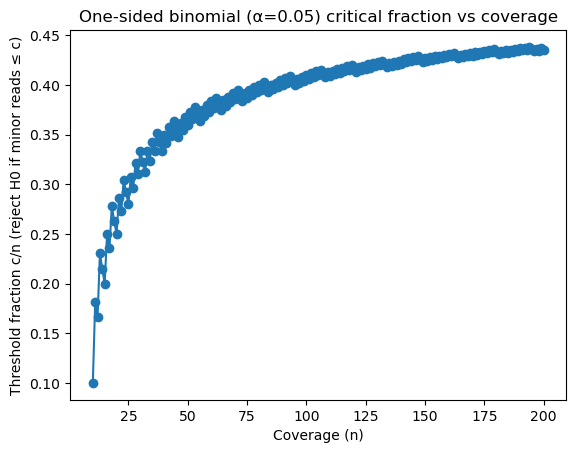

In [4]:
# Plot coverage vs c/n
plt.figure()
plt.plot(df["coverage_n"], df["c_over_n"], marker='o')
plt.xlabel("Coverage (n)")
plt.ylabel("Threshold fraction c/n (reject H0 if minor reads ≤ c)")
plt.title("One-sided binomial (α=0.05) critical fraction vs coverage")
plt.show()
